In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib

import os
import numpy as np
from openTSNE.affinity import Affinities
from vis_utils.tsne_wrapper import TSNEwrapper
from firelight.visualizers.colorization import get_distinct_colors


import sys
sys.path.append("..")
from scripts.utils import get_path
from vis_utils.loaders import load_dataset, label_to_time, label_to_color
from vis_utils.utils import  save_dict, load_dict
from vis_utils.plot import plot_scatter
import pickle
import umap
import ncvis
from firelight.visualizers.colorization import get_distinct_colors

env: CUDA_VISIBLE_DEVICES=1


In [2]:
root_path = get_path("data")
fig_path = get_path("figures")

In [13]:
# parameters for all methods
a = 1.0
b = 1.0
seed = 0
seeds = [0, 1, 2]
n_noise = 5

k = 15
dataset = "c_elegans"

In [4]:
plt.style.use("default")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"


In [5]:
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset, k)
print(x.shape)

(86024, 100)


In [8]:
unnamed_label = 36

np.random.seed(0)
colors = get_distinct_colors(len(np.unique(y)))
np.random.shuffle(colors)
colors[unnamed_label] = [0.5, 0.5, 0.5]
cmap = matplotlib.colors.ListedColormap(colors)

special_order = np.argsort(y != unnamed_label, kind="stable") # put idx of unnamed label to the front


<AxesSubplot:>

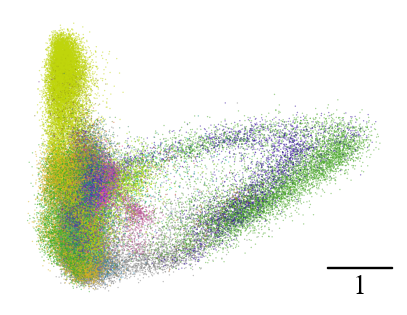

In [9]:
# pca sanity check
pca2_rescaled = pca2 / np.std(pca2[:, 0]) * 1.0
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(),pca2_rescaled[special_order], y[special_order], cmap=cmap)

In [9]:
## tsne

In [10]:
n_early_epochs = 250
n_epochs = 500
perplexity = 2*k
rescale_tsne = True
log_kl = False
log_embds = False
log_Z = True


if rescale_tsne:
    pca_tsne = pca2 / np.std(pca2[:, 0]) / 10000
else:
    pca_tsne = pca2


affinities_tSNE = Affinities()
affinities_tSNE.P = (sknn_graph / sknn_graph.sum()).tocsr()

In [11]:
tsne_data_list = []
for s in seeds:
    file_name = os.path.join(root_path,
                             dataset,
                             f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{s}_init_pca_rescale_{rescale_tsne}.pkl")
    try:
        tsne_data = load_dict(file_name)
    except FileNotFoundError:
        tsne = TSNEwrapper(perplexity=perplexity,
                           metric="euclidean",
                           n_jobs=5, # n_jobs=-10 does not work well, the cell does not print anything
                           random_state=s,
                           verbose=True,
                           n_iter = n_epochs,
                           early_exaggeration_iter = n_early_epochs,
                           callbacks_every_iters=1,
                           log_kl=log_kl,
                           log_embds=log_embds,
                           log_Z=log_Z,
                           initialization=pca_tsne)
        embd = tsne.fit_transform(x, affinities=affinities_tSNE)

        save_dict(tsne.aux_data, file_name)
        tsne_data = tsne.aux_data
    tsne_data_list.append(tsne_data)

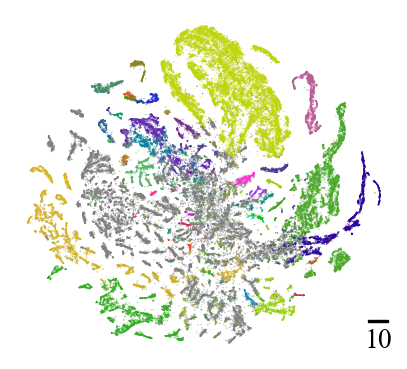

In [12]:
epoch = -1
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), tsne_data_list[0]["embd"][special_order] , y[special_order], cmap=cmap )

plt.savefig(os.path.join(fig_path,
                         f"tsne_{dataset}_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_init_pca_rescale_{rescale_tsne}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor='white')

In [13]:
norms = np.array([float(tsne_data["Zs"][-1].cpu().numpy()) for tsne_data in tsne_data_list])
print("{:.2E}".format(norms.mean()))
print("{:.2E}".format(norms.std()))

1.17E+07
0.00E+00


## UMAP

In [14]:
lr = 1.0
n_epochs = 750
rescale_umap = 1.0

if rescale_umap:
    pca_umap = pca2 / np.std(pca2[:, 0]) * rescale_umap
else:
    pca_umap = pca2

In [15]:
filename = os.path.join(root_path, dataset, f"umap_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.pkl")
try:
    with open(filename, "rb") as file:
        umapper = pickle.load(file)
        embd_umap = umapper.embedding_
except FileNotFoundError:
    umapper = umap.UMAP(n_neighbors=k,
                        n_epochs=n_epochs,
                        log_losses=None,
                        a=a,
                        b=b,
                        log_embeddings=True,
                        log_norm=False,
                        log_kl=False,
                        random_state=seed,
                        verbose=True,
                        init=pca_umap,
                        graph=sknn_graph,
                        learning_rate=lr)
    embd = umapper.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

UMAP(a=1.0, b=1.0, dens_frac=0.0, dens_lambda=0.0,
     init=array([[-0.42984614,  1.07351258],
       [-0.36339734, -0.8884654 ],
       [ 1.55993578, -0.4130965 ],
       ...,
       [-0.63591425, -0.1464273 ],
       [-0.43961601, -0.30839183],
       [-0.33116   , -0.84751786]]),
     log_embeddings=True, n_epochs=750, random_state=2, verbose=True)
Construct fuzzy simplicial set
Fri Nov 18 11:40:49 2022 Construct embedding


/export/data/sdamrich/anaconda3/envs/nce/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Fri Nov 18 11:53:06 2022 Finished embedding


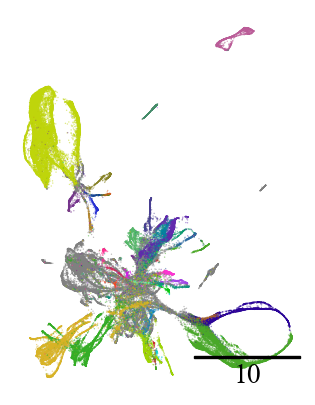

In [16]:
epoch=-1
plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), umapper.aux_data["embeddings"][epoch][special_order], y[special_order], cmap=cmap)

plt.savefig(os.path.join(fig_path,
                         f"umap_{dataset}_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor="white")

## NCVis

In [17]:
n_epochs = 750
rescale = 1.0
alpha = 1.0
alpha_Q = 0.001
n_noise = 5
noise_in_ratio = n_noise
fix_Q = False
learn_Q = True
affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)

In [18]:
ncvis_list = []
for s in seeds:
    file_name = os.path.join(root_path,
                                 dataset,
                                 f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{s}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
    if rescale:
        pca_ncvis = pca2 / np.std(pca2[:, 0]) * rescale
    else:
        pca_ncvis = pca2
    try:
        ncvis_data = load_dict(file_name)
    except FileNotFoundError:
        ncvisualizer = ncvis.NCVis(n_epochs=n_epochs,
                                   random_seed=s,
                                   fix_Q=fix_Q,
                                   noise_in_ratio=noise_in_ratio,
                                   learn_Q=learn_Q,
                                   n_noise=n_noise,
                                   alpha=alpha,
                                   alpha_Q=alpha_Q,
                                   a=a,
                                   b=b)

        embd = ncvisualizer.fit_transform(x,
                                          affinities=affinities,
                                          init=pca_ncvis,
                                          log_embds=True,
                                          log_nce=False,
                                          log_nce_norm=False,
                                          log_nce_no_noise=False)
        ncvis_data = ncvisualizer.aux_data

        save_dict(ncvis_data, file_name)
    ncvis_list.append(ncvis_data)

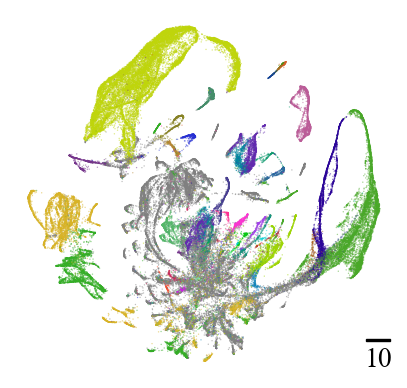

In [19]:
epoch=-1
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), ncvis_list[0]["embds"][epoch][special_order], y[special_order], cmap=cmap)
plt.savefig(os.path.join(fig_path,
                         f"ncvis_{dataset}_bin_k_{k}_n_epochs_{n_epochs}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=200,
            transparent=False,
            facecolor="white")

In [20]:
norms = np.array([ncvis_data["normalization"][-1] for ncvis_data in ncvis_list])
zs = np.array(
    [np.exp(ncvis_data["qs"][-1]) for ncvis_data in ncvis_list]) * len(x) * (
                 len(x) - 1)  # rescale with noise distribution


In [21]:
print("{:.2E}".format(norms.mean()))
print("{:.2E}".format(norms.std()))

1.90E+07
1.19E+05


In [22]:
print("{:.2E}".format(zs.mean()))
print("{:.2E}".format(zs.std()))

3.69E+07
7.40E+05


In [23]:
_, counts = np.unique(y, return_counts=True)

In [24]:
counts

array([  273,   434, 17520,  6090,  4468,   787,   215,    62,    91,
         205,    72,   768,   499,  1857,  7746,   568,  1732,   315,
          61,   114,    75,   786,   493,   911,  2562,  1471,   327,
         265,  2766,   141,    25,   372,   189,   122,   155,   112,
       31375])